In [6]:
## Set DATA_FOLDER
DATA_FOLDER <- '~/Resilio\ Sync/FXBootcamp'

## Get Hourly Exchange Rate Data
source(paste0('data-utils.R'))

asset_list <- get_asset_list("AssetsDWX-FX-USD")
raw_prices_df <- get_hourly_OHLC(asset_list$Name)
usd_prices_df <- convert_common_quote_currency(raw_prices_df, quote_currency = 'USD')
assetNames <- distinct(usd_prices_df, Ticker) 

## Calculate Returns and Convert to Eastern Time
usd_returns <-  usd_prices_df %>%
  group_by(Ticker) %>%
  mutate(returns = Close / lag(Close) - 1)

datetime <- as.POSIXct(paste(usd_returns$Date, usd_returns$Time), format="%Y-%m-%d %H:%M", tz='UTC')
attributes(datetime)$tzone <- 'America/New_York'
usd_returns$datetime <- datetime

returns_df <- usd_returns %>%
  mutate(hour = hour(datetime),
         year = year(datetime),
         month = month(datetime),
         day = day(datetime)) %>%
  select(Ticker, datetime, hour, year, month, day, returns) %>%
  na.omit()

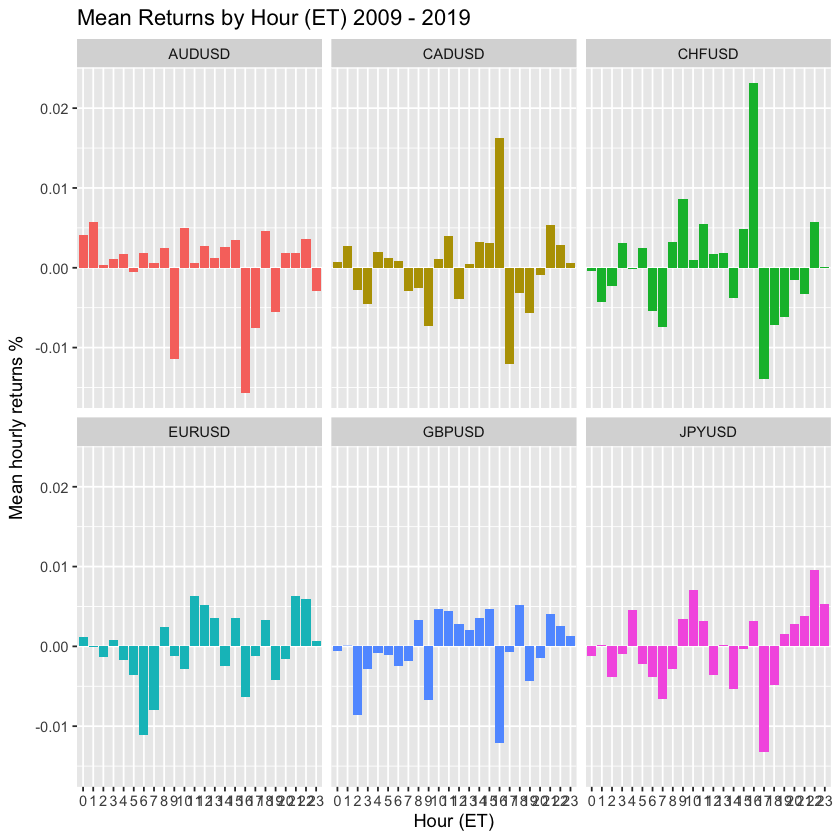

In [7]:
## Full Sample Seasonality Plots
seasonality_barplot <- function(ticker_subset = 'EURUSD', years_subset = 2009:2019) {
  returns_df %>%
    filter(Ticker %in% ticker_subset) %>%
    filter(year %in% years_subset) %>%
    group_by(Ticker, hour) %>%
    summarise(meanreturns = mean(returns * 100)) %>%
    ggplot(aes(x=as.factor(hour), y=meanreturns, fill = Ticker)) +
    geom_bar(stat='identity', position = position_dodge()) +
    labs(title = paste('Mean Returns by Hour (ET)', years_subset[1], '-', years_subset[length(years_subset)])) +
    xlab("Hour (ET)") + 
    ylab("Mean hourly returns %") +
    facet_wrap(~Ticker) +
    theme(legend.position = 'none')
}


## Subset of currencies to plot
ticker_subset <- c('EURUSD','GBPUSD','CADUSD', 'JPYUSD','AUDUSD','CHFUSD')

## Plot
seasonality_barplot(ticker_subset)

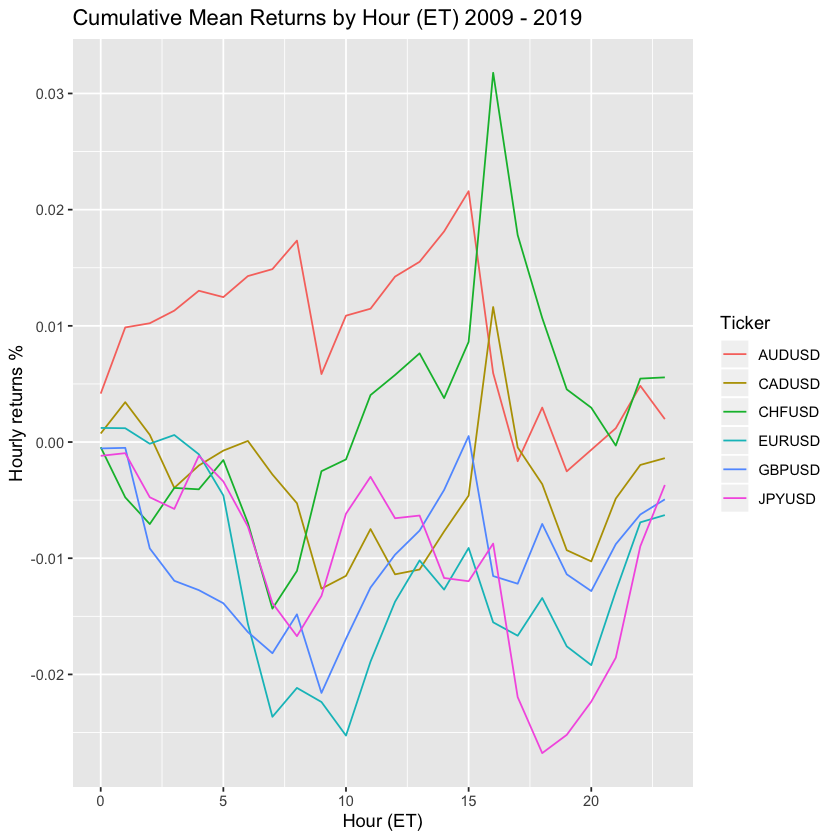

In [8]:
## Cumulative Returns for Multiple Currencies
seasonality_cumline <- function(ticker_subset = 'EURUSD', years_subset = 2009:2019) {
  returns_df %>%
    filter(Ticker %in% ticker_subset) %>%
    filter(year %in% years_subset) %>%
    group_by(Ticker, hour) %>%
    summarise(meanreturns = mean(returns * 100)) %>%
    mutate(cumreturns = cumsum(meanreturns)) %>%
    ggplot(aes(x=hour, y=cumreturns, color = Ticker)) +
    geom_line() +
    labs(title = paste('Cumulative Mean Returns by Hour (ET)', years_subset[1], '-', years_subset[length(years_subset)])) +
    xlab("Hour (ET)") + 
    ylab("Hourly returns %")
}  

seasonality_cumline(ticker_subset)

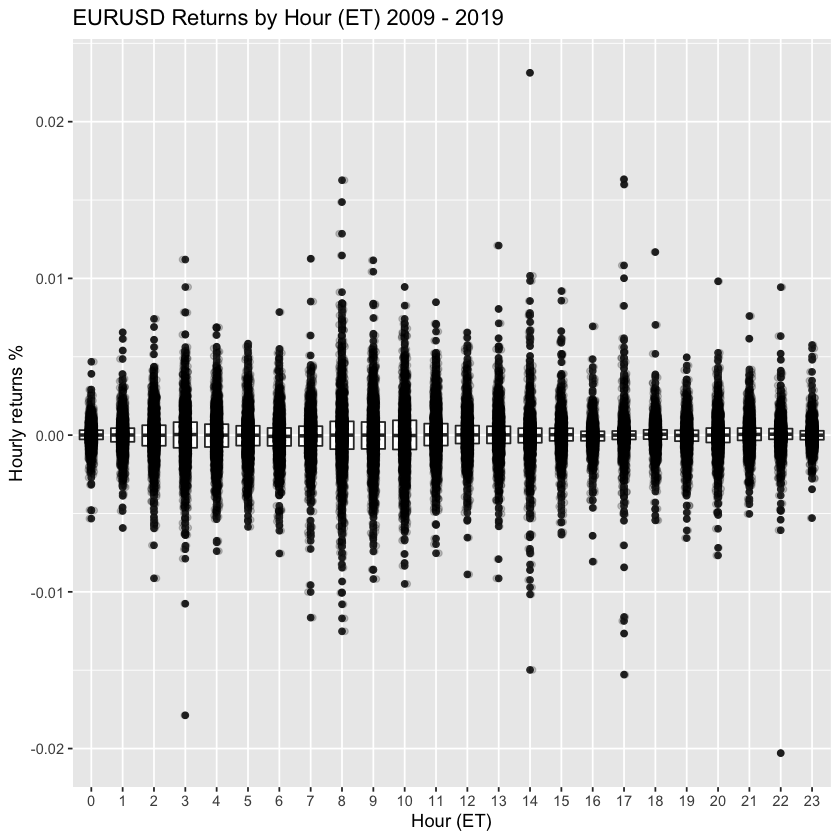

In [9]:
## Seasonality boxplot
seasonality_boxplot <- function(ticker = 'EURUSD', years_subset = 2009:2019) {
  returns_df %>%
    filter(Ticker %in% ticker) %>%
    filter(year %in% years_subset) %>%
    ggplot(aes(x=as.factor(hour), y=returns)) +
    geom_boxplot() +
    geom_jitter(width=0.1, alpha=0.2) +
    xlab("Hour (ET)") + 
    ylab("Hourly returns %") +
    labs(title = paste(ticker, 'Returns by Hour (ET)', years_subset[1], '-', years_subset[length(years_subset)]))
}

seasonality_boxplot('EURUSD')

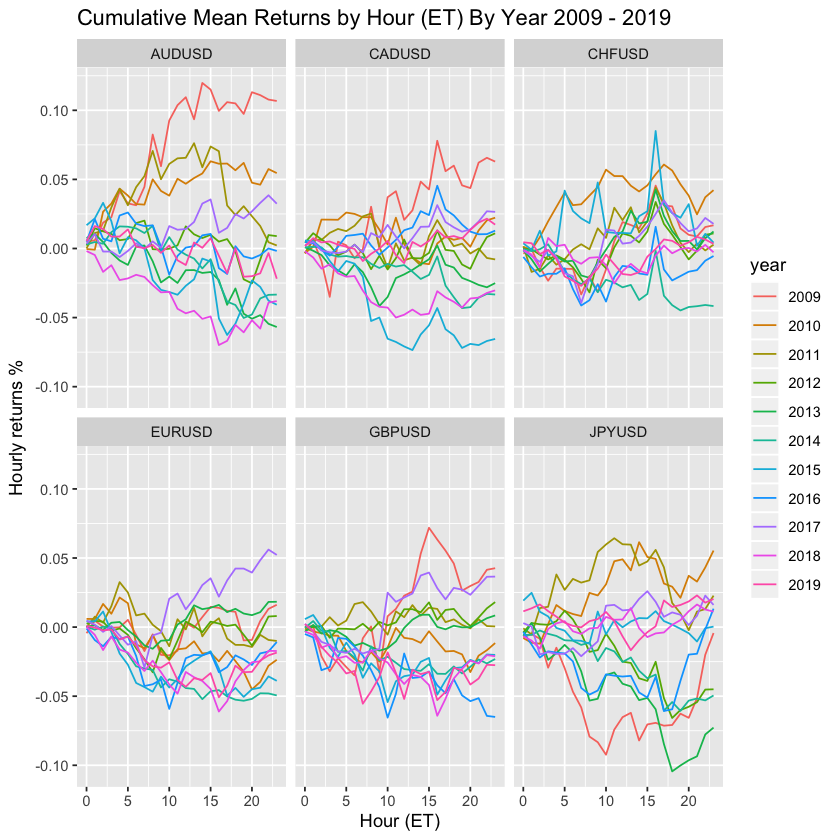

In [10]:
# Cumulative Returns by Currency by Year
seasonality_cumline_year <- function(ticker_subset = 'EURUSD', years_subset = 2009:2019) {
  returns_df %>%
    filter(Ticker %in% ticker_subset) %>%
    filter(year %in% years_subset) %>%
    mutate(year = as.factor(year)) %>%
    group_by(Ticker, year, hour) %>%
    summarise(meanreturns = mean(returns * 100)) %>%
    mutate(cumreturns = cumsum(meanreturns)) %>%
    ggplot(aes(x=hour, y=cumreturns, color = year)) +
    geom_line() +
    labs(title = paste('Cumulative Mean Returns by Hour (ET) By Year', years_subset[1], '-', years_subset[length(years_subset)])) +
    xlab("Hour (ET)") + 
    ylab("Hourly returns %") +
    facet_wrap(~Ticker)
}  

seasonality_cumline_year(ticker_subset)

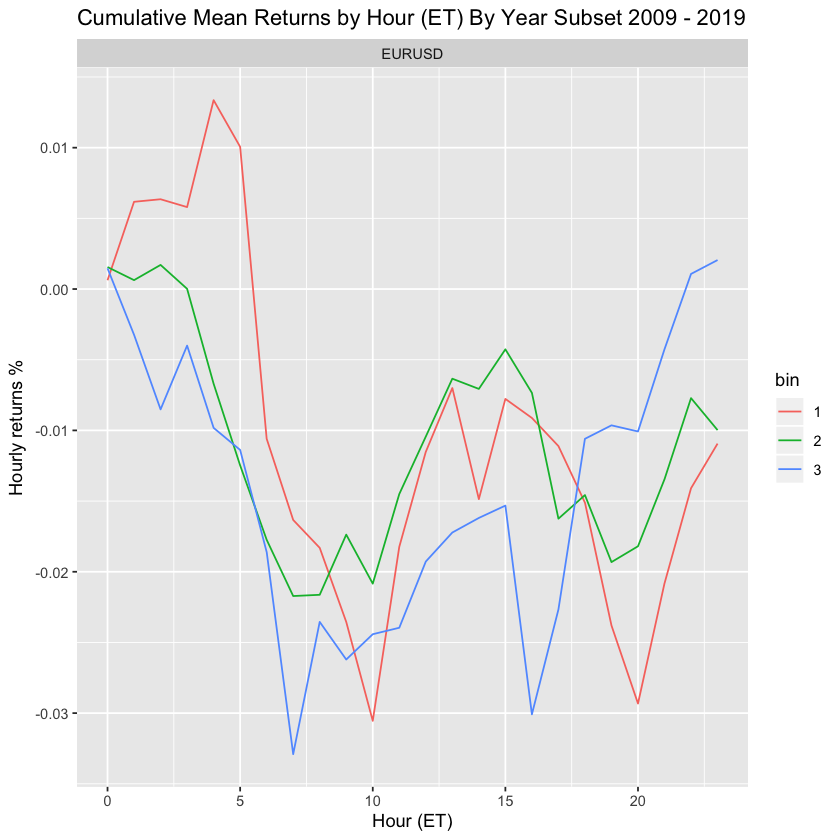

In [11]:
DATA_FOLDER <- '~/Resilio\ Sync/FXBootcamp'

## Get Hourly Exchange Rate Data
source(paste0('data-utils.R'))

# Get Exchange rate data and convert dates to ET
usd_returns <-  usd_prices_df %>%
    group_by(Ticker) %>%
    mutate(returns = Close / lag(Close) - 1)

asset_list <- get_asset_list("AssetsDWX-FX-USD")
raw_prices_df <- get_hourly_OHLC(asset_list$Name)
usd_prices_df <- convert_common_quote_currency(raw_prices_df, quote_currency = 'USD')
assetNames <- distinct(usd_prices_df, Ticker) 

datetime <- as.POSIXct(paste(usd_returns$Date, usd_returns$Time), format="%Y-%m-%d %H:%M", tz='UTC')
attributes(datetime)$tzone <- 'America/New_York'
usd_returns$datetime <- datetime

# Calculate returns
returns_df <- usd_returns %>%
  mutate(hour = hour(datetime),
         year = year(datetime),
         month = month(datetime),
         day = day(datetime)) %>%
  select(Ticker, datetime, hour, year, month, day, returns) %>%
  na.omit()

# Create seasonality plots
ticker_subset <- c('EURUSD','GBPUSD','CADUSD', 'JPYUSD','AUDUSD','CHFUSD')

seasonality_year_bin <- function(ticker_subset = 'EURUSD', years_subset = 2009:2019, bins = 2) {
  returns_df %>%
    filter(Ticker %in% ticker_subset) %>%
    filter(year %in% years_subset) %>%
    mutate(bin = ntile(year, bins)) %>%
    mutate(bin = as.factor(bin)) %>%
    group_by(Ticker, bin, hour) %>%
    summarise(meanreturns = mean(returns * 100)) %>%
    mutate(cumreturns = cumsum(meanreturns)) %>%
    ggplot(aes(x=hour, y=cumreturns, color = bin)) +
      geom_line() +
      labs(title = paste('Cumulative Mean Returns by Hour (ET) By Year Subset', years_subset[1], '-', years_subset[length(years_subset)])) +
    xlab("Hour (ET)") + 
    ylab("Hourly returns %") +
    facet_wrap(~Ticker)
}  

seasonality_year_bin('EURUSD', bins = 3)

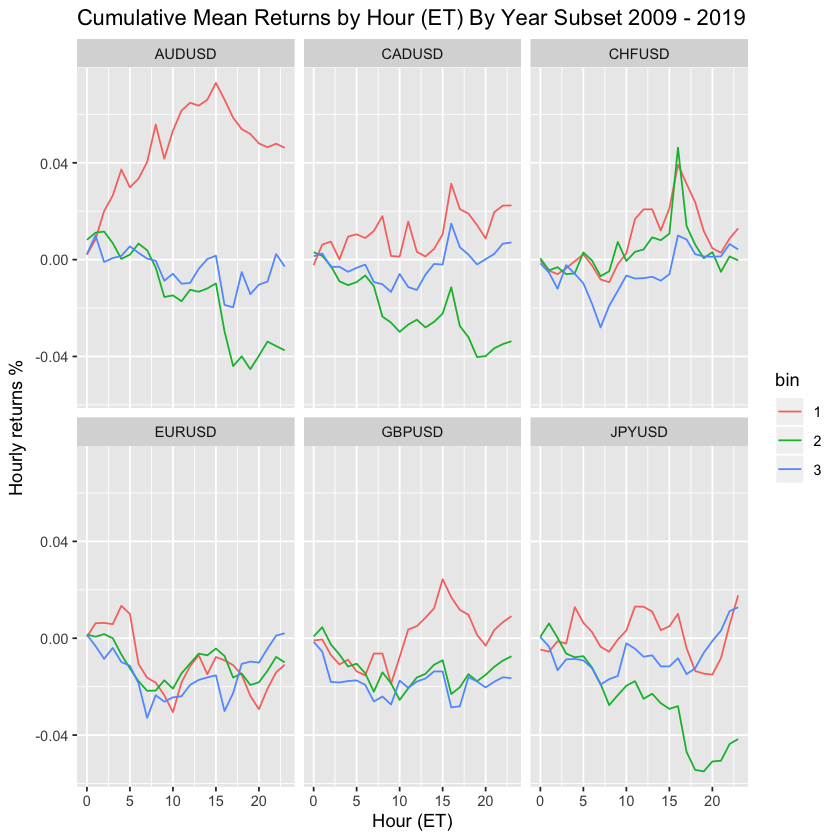

In [12]:
asset_list <- get_asset_list("AssetsDWX-FX-USD")
raw_prices_df <- get_hourly_OHLC(asset_list$Name)
usd_prices_df <- convert_common_quote_currency(raw_prices_df, quote_currency = 'USD')
assetNames <- distinct(usd_prices_df, Ticker) 

datetime <- as.POSIXct(paste(usd_returns$Date, usd_returns$Time), format="%Y-%m-%d %H:%M", tz='UTC')
attributes(datetime)$tzone <- 'America/New_York'
usd_returns$datetime <- datetime

# Calculate returns
returns_df <- usd_returns %>%
  mutate(hour = hour(datetime),
         year = year(datetime),
         month = month(datetime),
         day = day(datetime)) %>%
  select(Ticker, datetime, hour, year, month, day, returns) %>%
  na.omit()

# Create seasonality plots
ticker_subset <- c('EURUSD','GBPUSD','CADUSD', 'JPYUSD','AUDUSD','CHFUSD')

seasonality_year_bin <- function(ticker_subset = 'EURUSD', years_subset = 2009:2019, bins = 2) {
  returns_df %>%
    filter(Ticker %in% ticker_subset) %>%
    filter(year %in% years_subset) %>%
    mutate(bin = ntile(year, bins)) %>%
    mutate(bin = as.factor(bin)) %>%
    group_by(Ticker, bin, hour) %>%
    summarise(meanreturns = mean(returns * 100)) %>%
    mutate(cumreturns = cumsum(meanreturns)) %>%
    ggplot(aes(x=hour, y=cumreturns, color = bin)) +
      geom_line() +
      labs(title = paste('Cumulative Mean Returns by Hour (ET) By Year Subset', years_subset[1], '-', years_subset[length(years_subset)])) +
    xlab("Hour (ET)") + 
    ylab("Hourly returns %") +
    facet_wrap(~Ticker)
}  

seasonality_year_bin(ticker_subset, bins = 3)

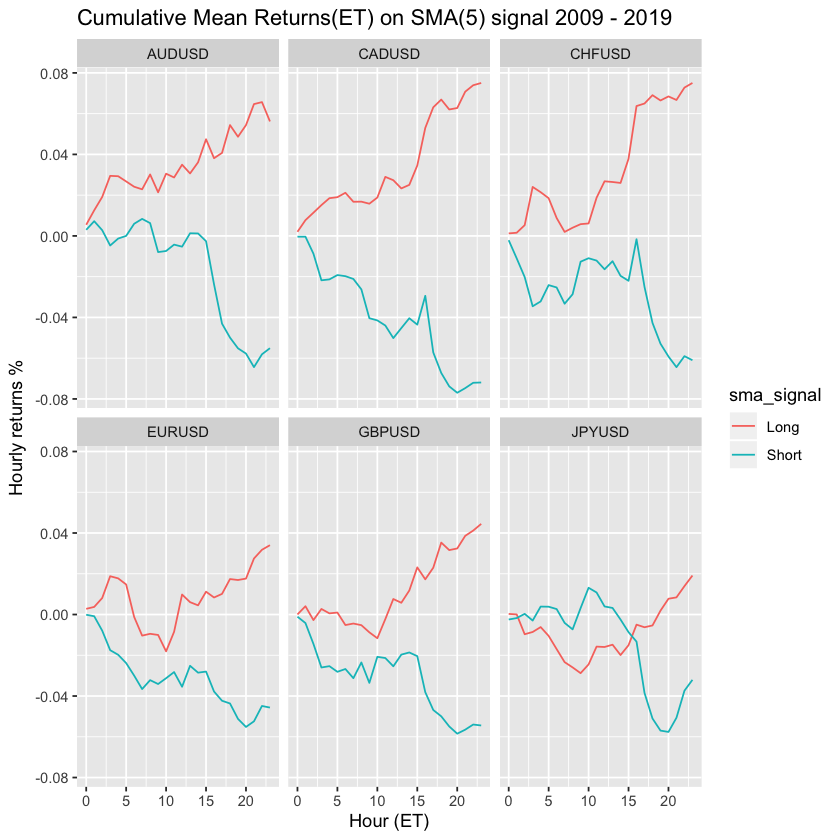

In [13]:
asset_list <- get_asset_list("AssetsDWX-FX-USD")
raw_prices_df <- get_hourly_OHLC(asset_list$Name)
usd_prices_df <- convert_common_quote_currency(raw_prices_df, quote_currency = 'USD')

# Calculate returns and convert to ET
usd_returns <-  usd_prices_df %>%
    group_by(Ticker) %>%
    mutate(returns = Close / lag(Close) - 1)

datetime <- as.POSIXct(paste(usd_returns$Date, usd_returns$Time), format="%Y-%m-%d %H:%M", tz='UTC')
attributes(datetime)$tzone <- 'America/New_York'
usd_returns$datetime <- datetime

returns_df <- usd_returns %>%
  mutate(hour = hour(datetime),
         year = year(datetime),
         month = month(datetime),
         day = day(datetime)) %>%
  select(Ticker, datetime, hour, year, month, day, returns) %>%
  na.omit()
  
# Subset of currencies
ticker_subset <- c('EURUSD','GBPUSD','CADUSD', 'JPYUSD','AUDUSD','CHFUSD')

# Create cumulative seasonality plots conditional on counter-trend signal.
#
# - Long condition: Price < 5 hour SMA
# - Short condition: Price > 5 hour SMA

# Calculate long/short condition
sma_period <- 5

factor_returns_df <- suppressWarnings(usd_returns %>%
  select(-Date, -Time) %>%
  # SMA
  group_by(Ticker) %>%
  tq_mutate(select = Close,
            mutate_fun = SMA,
            n = sma_period) %>%
  mutate(sma_signal = lag(case_when(Close > SMA ~ 'Short', TRUE ~ 'Long'))) %>%
  mutate(hour = hour(datetime),
         year = year(datetime),
         month = month(datetime),
         day = day(datetime)) %>%
  na.omit())

# Long/Short Seasonality plot for full period
seasonality_momentumcondition <- function(ticker_subset = 'EURUSD', years_subset = 2009:2019) {
  factor_returns_df %>%
    filter(Ticker %in% ticker_subset) %>%
    filter(year %in% years_subset) %>%
    group_by(Ticker, sma_signal, hour) %>%
    summarise(meanreturns = mean(returns * 100)) %>%
    mutate(cumreturns = cumsum(meanreturns)) %>%
    ggplot(aes(x=hour, y=cumreturns, color = sma_signal)) +
      geom_line() +
      labs(title = paste('Cumulative Mean Returns(ET) on SMA(5) signal', years_subset[1], '-', years_subset[length(years_subset)])) +
    xlab("Hour (ET)") + 
    ylab("Hourly returns %") +
    facet_wrap(~Ticker)
}  

seasonality_momentumcondition(ticker_subset)

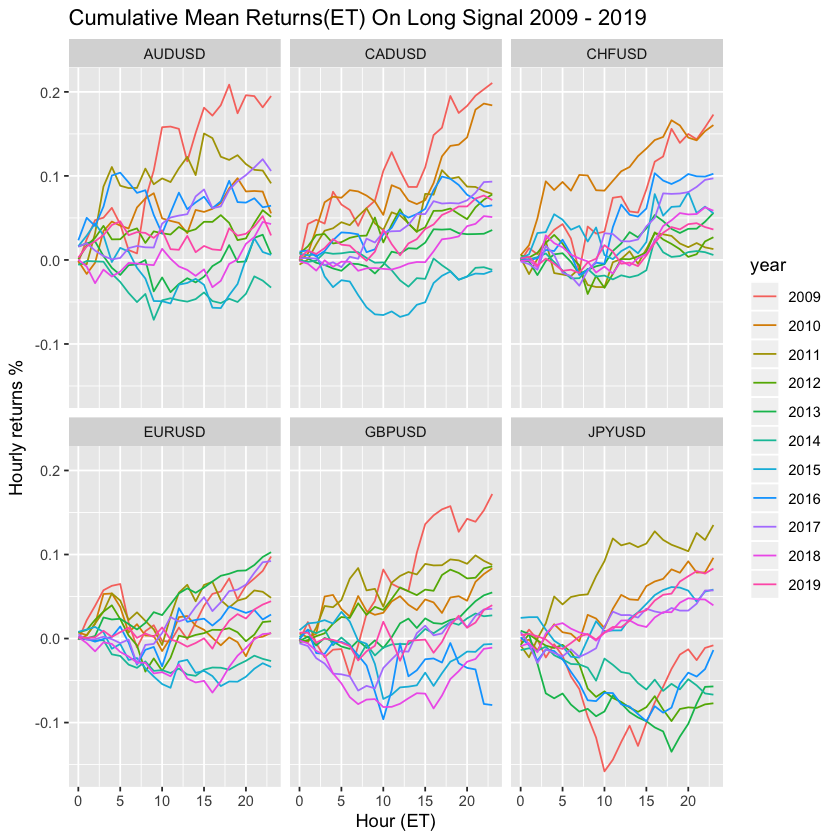

In [14]:
seasonality_long_year <- function(ticker_subset = 'EURUSD', years_subset = 2009:2019) {
  factor_returns_df %>%
    filter(Ticker %in% ticker_subset) %>%
    filter(year %in% years_subset) %>%
    filter(sma_signal == 'Long') %>%
    mutate(year = as.factor(year)) %>%
    group_by(Ticker, year, hour) %>%
    summarise(meanreturns = mean(returns * 100)) %>%
    mutate(cumreturns = cumsum(meanreturns)) %>%
    ggplot(aes(x=hour, y=cumreturns, color = year)) +
      geom_line() +
      labs(title = paste('Cumulative Mean Returns(ET) On Long Signal', years_subset[1], '-', years_subset[length(years_subset)])) +
    xlab("Hour (ET)") + 
    ylab("Hourly returns %") +
    facet_wrap(~Ticker)
}  

seasonality_long_year(ticker_subset)

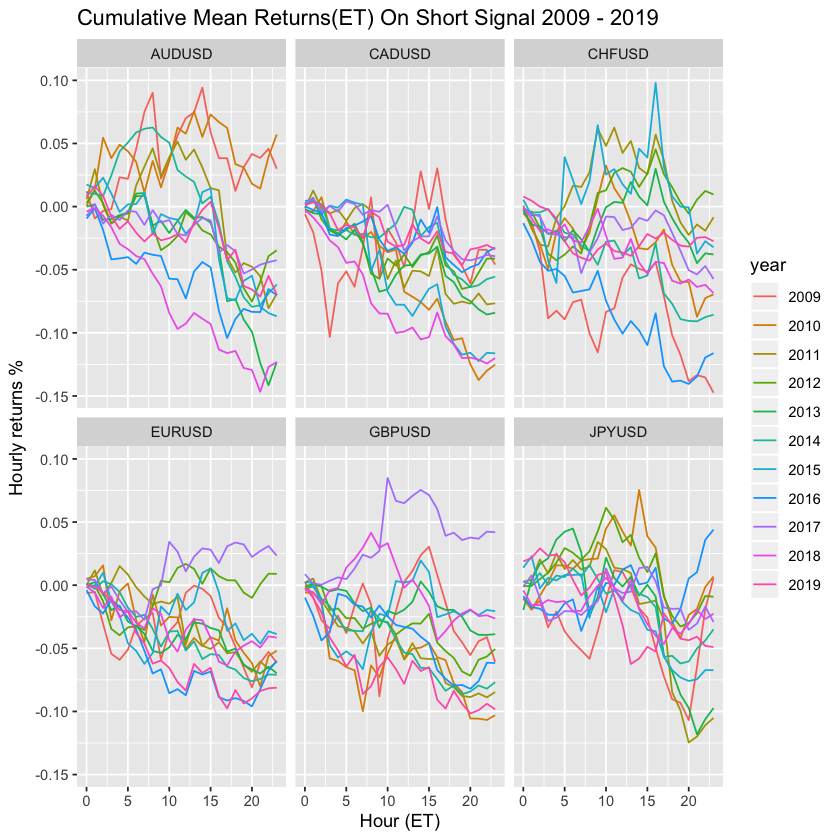

In [15]:
seasonality_short_year <- function(ticker_subset = 'EURUSD', years_subset = 2009:2019) {
  factor_returns_df %>%
    filter(Ticker %in% ticker_subset) %>%
    filter(year %in% years_subset) %>%
    filter(sma_signal == 'Short') %>%
    mutate(year = as.factor(year)) %>%
    group_by(Ticker, year, hour) %>%
    summarise(meanreturns = mean(returns * 100)) %>%
    mutate(cumreturns = cumsum(meanreturns)) %>%
    ggplot(aes(x=hour, y=cumreturns, color = year)) +
      geom_line() +
      labs(title = paste('Cumulative Mean Returns(ET) On Short Signal', years_subset[1], '-', years_subset[length(years_subset)])) +
    xlab("Hour (ET)") + 
    ylab("Hourly returns %") +
    facet_wrap(~Ticker)
}  

seasonality_short_year(ticker_subset)